In [16]:
import eda_prep as ep
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

| Feature Name       | Description |
|--------------------|-------------|
| **MPU_falls** | Raw MPU sensory data with Meta variables added |
| **MPU_features** | MPU feature extracted data with Meta variables |
| **MPU_falls_demean** | MPU sensory data after substracting 9.44 with Meta variables added |
| **MPU_demean_features** | MPU feature extracted data after substracting 9.44 with Meta variables added |

* No dataleakage as 9.44 is average of STILL recordings

In [2]:
# Load file S_0_0_0_H in folder MPU6050 with pd.read_csv

# Load MPU6050 data
path = os.path.join(os.getcwd(), 'MPU6050')
file = 'S_0_0_0_H.csv'

df = pd.read_csv(os.path.join(path, file))

# Print average value over whole dataset (columns and rows)
print('Average value of the dataset:', df.mean().mean().round(2))

Average value of the dataset: 9.44


In [25]:
def add_features(df):
    """
    Adds features of signal data for each row.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing signal data.
    - sampling_interval (float): The time interval between each sample.

    Returns:
    - pd.DataFrame: The DataFrame with the new features.
    """
    # Signal data starts from column index 6
    signal_columns = df.columns[5:]

    # Sampling interval (in seconds)
    sampling_interval=4.5/500

    # Compute values
    df['max'] = df[signal_columns].max(axis=1) # Compute max value
    df['min'] = df[signal_columns].min(axis=1) # Compute min value
    df['mean'] = df[signal_columns].mean(axis=1) # Compute mean value
    df['std'] = df[signal_columns].std(axis=1) # Compute standard deviation
    df['median'] = df[signal_columns].median(axis=1) # Compute median value
    df['peak'] = df[signal_columns].abs().max(axis=1) # Compute peak value
    df['p2p'] = df['max'] - df['min'] # Compute peak-to-peak value (range)
    df['energy'] = df['peak'] * sampling_interval # Compute energy using numerical integration (Riemann sum approximation)
    df['rms'] = df['std'] / (2 ** 0.5) # Compute root mean square
    df['crest'] = df['peak'] / df['rms'] # Compute crest factor
    df['shape'] = df['peak'] / df['mean'] # Compute shape factor
    df['impulse'] = df['peak'] * sampling_interval / df['mean'] # Compute impulse factor
    df['margin'] = df['peak'] / (df['mean'] + 1e-10) # Compute margin factor

    return df

In [26]:
def normalize(df):
    """
    Normalizes the features of the signal data.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing signal data.

    Returns:
    - pd.DataFrame: The DataFrame with the normalized features.
    """
    # Signal data starts from column index 6
    signal_columns = df.columns[5:]

    # Normalize signal data
    df[signal_columns] = (df[signal_columns] - df[signal_columns].mean()) / df[signal_columns].std()

    return df

In [27]:
# Import the csv MPU_falls.csv in folder datasets
df = pd.read_csv('datasets/geophone.csv')

df = add_features(df)

# delete all column that start with value
df = df.loc[:, ~df.columns.str.startswith('value')]

# Save the new dataset
df.to_csv('datasets/geophone_features.csv', index=False)

In [28]:
# Import the csv MPU_falls.csv in folder datasets
df = pd.read_csv('datasets/geophone.csv')

df = normalize(df)

# Save the new dataset
df.to_csv('datasets/geophone_normalized.csv', index=False)

In [ ]:
# Import the csv MPU_falls.csv in folder datasets
df = pd.read_csv('datasets/MPU_falls.csv')

# From each column that starts with value, substract 9.44
df.loc[:, df.columns.str.startswith
('value')] = df.loc[:, df.columns.str.startswith('value')].sub(9.44)

# Save the new dataset
df.to_csv('datasets/MPU_falls_demean.csv', index=False)

  activity  fall_binary  distance_m person_binary floor  value_1  value_2  \
0      FCS            1           1            AD     H    -0.01     0.00   
1      FCS            1           1            AD     H    -0.01     0.01   
2      FCS            1           1            AD     H     0.00     0.00   
3      FCS            1           1            AD     H    -0.02     0.01   
4      FCS            1           1            AD     H     0.00    -0.01   

   value_3  value_4  value_5  ...  value_491  value_492  value_493  value_494  \
0    -0.02    -0.01    -0.02  ...      -0.03      -0.02      -0.02      -0.02   
1     0.00     0.00     0.01  ...      -0.01      -0.01      -0.02       0.00   
2     0.02     0.01    -0.01  ...      -0.05      -0.02      -0.03      -0.02   
3    -0.03    -0.01    -0.01  ...      -0.01      -0.05      -0.04      -0.03   
4    -0.03    -0.03    -0.03  ...      -0.03      -0.02      -0.02      -0.03   

   value_495  value_496  value_497  value_498  val

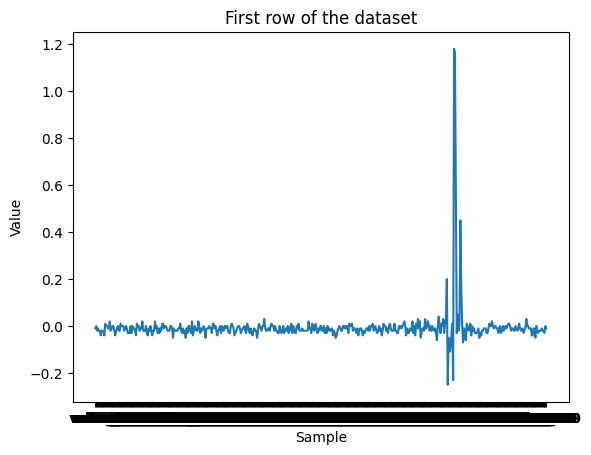

In [21]:
df_values = df.loc[:, df.columns.str.startswith('value')]

# plot the first row
plt.plot(df_values.iloc[0])
plt.title('First row of the dataset')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

In [29]:
# PCA components analysis for feature dataset
from sklearn.decomposition import PCA

# Load the feature dataset
df = pd.read_csv('datasets/geophone_features.csv')

# feature columns max,min,mean,std,median,peak,p2p,energy,rms,crest,shape,impulse,margin
X = df[['max', 'min', 'mean', 'std', 'median', 'peak', 'p2p', 'energy', 'rms', 'crest', 'shape', 'impulse', 'margin']]
y = df['fall_binary']

# Perform PCA
pca = PCA(n_components=3)

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Create a DataFrame for the PCA components
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])

# Add PCA components to the original DataFrame and remove all value.. columns
df = pd.concat([df, df_pca], axis=1)
df = df.loc[:, ~df.columns.str.startswith('value')]

# Save the new dataset
df.to_csv('datasets/geophone_features_pca.csv', index=False)
